dog.jpg exists
torch.Size([3, 300, 300])


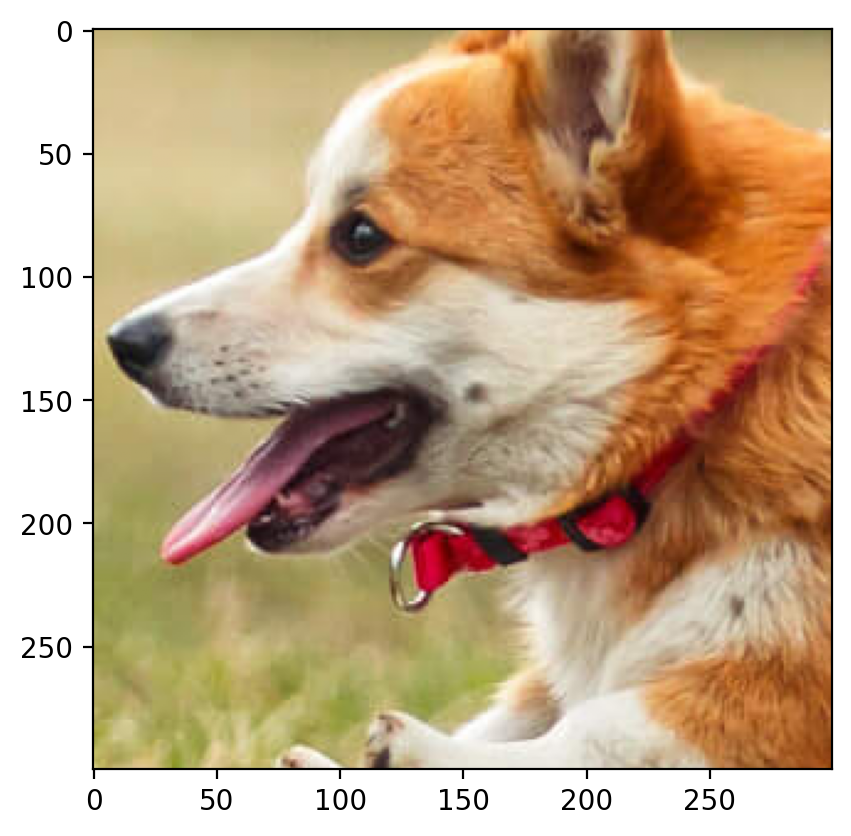

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange


# set device and os environemnt
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# os.environ['CUDA_LAUNCH_BLOCKING'] = '2'

if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

from sklearn import preprocessing
img = torchvision.io.read_image("dog.jpg")

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)

crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
print(crop.shape)

crop = crop.to(device)
num_channels, height, width = crop.shape


In [2]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y


dog_X, dog_Y = create_coordinate_map(crop, scale=1)

dog_X.shape, dog_Y.shape

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()



In [3]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)



In [22]:
import torch
import torch.nn as nn

def train(net, lr, X, Y, epochs, verbose=True, stopping_criteria=0.00001):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    # add stopping criteria if the improvement in loss is less than 0.0001

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    prev_loss = float('inf')  # Initialize with a large value

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

        if prev_loss - loss.item() <= stopping_criteria:
            print(f"Stopping criteria met. Improvement in loss less than or equal to {stopping_criteria:.6f}")
            break

        prev_loss = loss.item()

    return loss.item()
def plot_reconstructed_and_original_image(gt, original_img, net, X, title="" ):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs_reshaped = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax0.imshow(outputs_reshaped.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    ax2.imshow(gt.cpu().permute(1, 2, 0))
    ax2.set_title("GT Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return outputs

def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    # Convert to NumPy array
    X_numpy = X.cpu().numpy()
    # Apply RFF to the input features
    rff = RBFSampler(n_components=num_features, gamma=1 / (2 * sigma ** 2))
    X_transformed = rff.fit_transform(X_numpy)
    # Convert the result back to a PyTorch tensor
    return torch.tensor(X_transformed, dtype=torch.float32)


## Metrics:

### 1. PSNR:

The PSNR is calculated using the following formula:

$\text{PSNR} = 10 \cdot \log_{10}\left(\frac{\text{MAX}^2}{\text{MSE}}\right)$

where:
<br>&nbsp; &nbsp; &nbsp; &nbsp; - **MAX:** The maximum possible pixel value of the image (e.g., 255 for an 8-bit image).
<br>&nbsp; &nbsp; &nbsp; &nbsp; - **MSE:** The Mean Squared Error between the original and reconstructed images.

- It is expressed in decibels (dB) and higher values are indicative of better image quality.
- A higher PSNR suggests that the reconstructed image is closer to the original, as the signal power (image content) is much greater than the noise power (differences between the images).

### 2. RMSE:

The Root Mean Squared Error (RMSE) is a metric used to quantify the average pixel-wise difference between the original and reconstructed images. It is calculated using the following formula:

$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2} $

where:
- **$( \hat{y}_i $):** The predicted value.
- **$(y_i$):** The actual (ground truth) value.
- **$(n$):** The number of samples.

- RMSE provides an overall measure of the magnitude of differences between the original and predicted values.
- Lower RMSE values are generally desirable, indicating better agreement between the original and reconstructed images.
- RMSE is sensitive to outliers, meaning that large errors have a more significant impact on the overall metric.

In summary, RMSE is a useful metric for assessing the accuracy of a predictive model or reconstructed image, with lower values reflecting better performance.


In [23]:
import torch
import torch.nn.functional as F

def calculate_rmse(predicted, ground_truth):
    """
    Calculate Root Mean Squared Error (RMSE) between predicted and ground truth images.

    Parameters:
    - predicted: torch.Tensor of shape (x, num_features)
    - ground_truth: torch.Tensor of shape (x, num_features)

    Returns:
    - rmse: float, Root Mean Squared Error
    """
    rmse = torch.sqrt(F.mse_loss(predicted, ground_truth))
    return rmse.item()

def calculate_psnr(predicted, ground_truth, max_val=255):
    """
    Calculate Peak Signal-to-Noise Ratio (PSNR) between predicted and ground truth images.

    Parameters:
    - predicted: torch.Tensor of shape (x, num_features)
    - ground_truth: torch.Tensor of shape (x, num_features)
    - max_val: float, maximum pixel value (default is 1.0 for normalized images)

    Returns:
    - psnr: float, Peak Signal-to-Noise Ratio
    """
    mse = F.mse_loss(predicted, ground_truth)
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse))
    return psnr.item()




## Random Missing data  

- For entirely masked image, i.e. all the pixel values are set to '0', RMSE value is equal to 0.6113, which serves as a reference point for comparison. 

- Lower RMSE values are better, and signify a closer resemblance to the original image. 

- Specifically, the calculated RMSE of 0.6113 can be considered indicative of the worst-case scenario for reconstruction error. Therefore, for a well-performing reconstruction algorithm, RMSE values should consistently fall below this threshold, and any deviations may suggest a degradation in image fidelity.

Epoch 0 loss: nan
Epoch 100 loss: nan
Epoch 200 loss: nan
Epoch 300 loss: nan
Epoch 400 loss: nan
Epoch 500 loss: nan
Epoch 600 loss: nan
Epoch 700 loss: nan
Epoch 800 loss: nan
Epoch 900 loss: nan
Epoch 1000 loss: nan
Epoch 1100 loss: nan
Epoch 1200 loss: nan
Epoch 1300 loss: nan
Epoch 1400 loss: nan
Epoch 1500 loss: nan
Epoch 1600 loss: nan
Epoch 1700 loss: nan
Epoch 1800 loss: nan
Epoch 1900 loss: nan
Epoch 2000 loss: nan
Epoch 2100 loss: nan
Epoch 2200 loss: nan
Epoch 2300 loss: nan
Epoch 2400 loss: nan
Epoch 2500 loss: nan
Epoch 2600 loss: nan
Epoch 2700 loss: nan
Epoch 2800 loss: nan
Epoch 2900 loss: nan
Epoch 3000 loss: nan
Epoch 3100 loss: nan
Epoch 3200 loss: nan
Epoch 3300 loss: nan
Epoch 3400 loss: nan
Epoch 3500 loss: nan
Epoch 3600 loss: nan
Epoch 3700 loss: nan
Epoch 3800 loss: nan
Epoch 3900 loss: nan
Epoch 4000 loss: nan
Epoch 4100 loss: nan
Epoch 4200 loss: nan
Epoch 4300 loss: nan
Epoch 4400 loss: nan
Epoch 4500 loss: nan
Epoch 4600 loss: nan
Epoch 4700 loss: nan


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4800 loss: nan
Epoch 4900 loss: nan
---------------------------------------
RMSE: 0.610147601800438
PSNR: 52.42210543655438


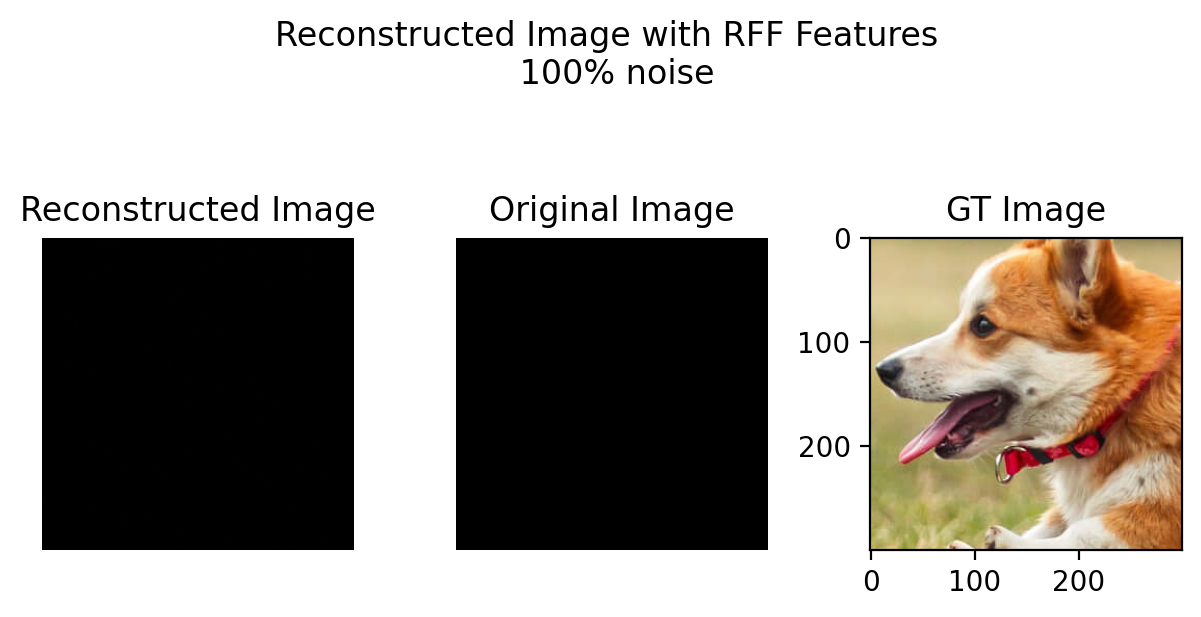

In [24]:
p_value = 1
mask = torch.rand(height*width) > p_value

X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff = X_rff.to(device)
# Remove elements where the mask is False
X_rff_mask = X_rff[mask]
X_rff.shape, X_rff_mask.shape

dog_Y_mask = dog_Y[mask]
dog_Y_mask = dog_Y_mask.to(device)
dog_Y_mask.shape

net = LinearModel(X_rff_mask.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_mask, dog_Y_mask, 5000)

crop = crop.to(device)
mask = mask.to(device)

outputs = plot_reconstructed_and_original_image( crop, crop*mask.reshape(300,300), net, X_rff, title="Reconstructed Image with RFF Features \n 100% noise")

rmse_value = calculate_rmse(outputs, crop.reshape(height*width, num_channels))
psnr_value = calculate_psnr(outputs, crop.reshape(height*width, num_channels))

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

### a. 10% data missing

Epoch 0 loss: 0.367121
Epoch 100 loss: 0.043206
Epoch 200 loss: 0.009302
Epoch 300 loss: 0.004498
Epoch 400 loss: 0.002544


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Stopping criteria met. Improvement in loss less than or equal to 0.000010
---------------------------------------
RMSE: 0.32108892726944455
PSNR: 57.998297024517846


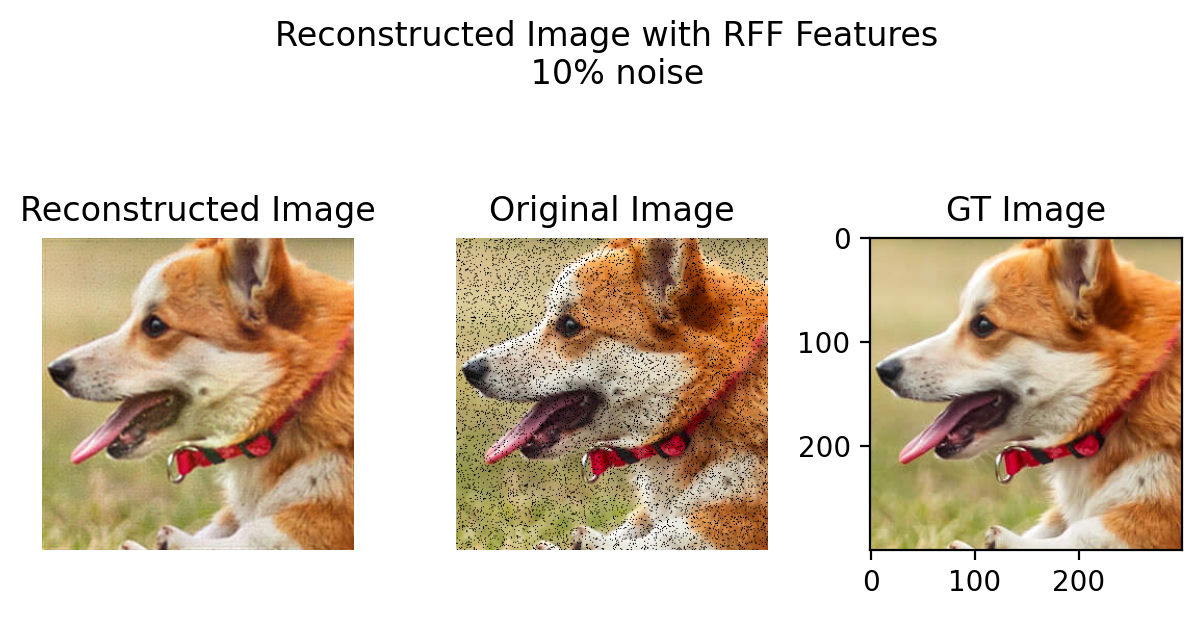

In [6]:
p_value = 0.1
mask = torch.rand(height*width) > p_value

X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff = X_rff.to(device)
# Remove elements where the mask is False
X_rff_mask = X_rff[mask]
X_rff.shape, X_rff_mask.shape

dog_Y_mask = dog_Y[mask]
dog_Y_mask = dog_Y_mask.to(device)
dog_Y_mask.shape

net = LinearModel(X_rff_mask.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_mask, dog_Y_mask, 5000)

crop = crop.to(device)
mask = mask.to(device)

outputs = plot_reconstructed_and_original_image( crop, crop*mask.reshape(300,300), net, X_rff, title="Reconstructed Image with RFF Features \n 10% noise")

rmse_value = calculate_rmse(outputs, crop.reshape(height*width, num_channels))
psnr_value = calculate_psnr(outputs, crop.reshape(height*width, num_channels))

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

### b. 20% data missing

Epoch 0 loss: 0.374247
Epoch 100 loss: 0.047119
Epoch 200 loss: 0.011470
Epoch 300 loss: 0.006264
Epoch 400 loss: 0.004225
Epoch 500 loss: 0.002960


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Stopping criteria met. Improvement in loss less than or equal to 0.000010
---------------------------------------
RMSE: 0.31797987054137156
PSNR: 58.082811044808466


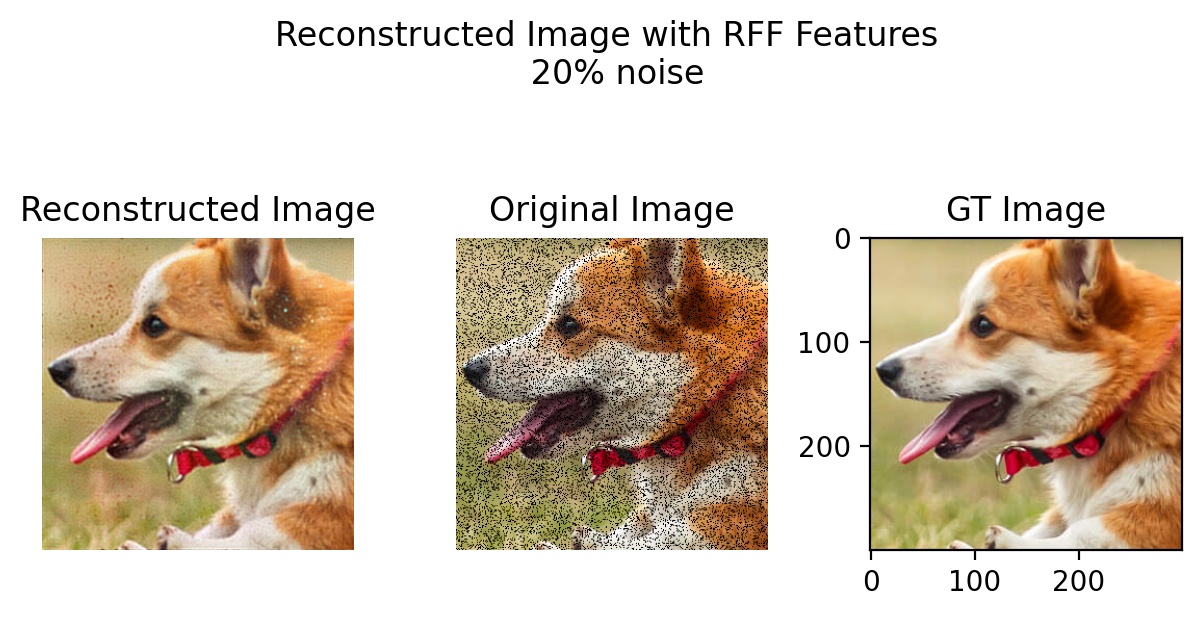

In [6]:
p_value = 0.2
mask = torch.rand(height*width) > p_value

X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff = X_rff.to(device)
# Remove elements where the mask is False
X_rff_mask = X_rff[mask]
X_rff.shape, X_rff_mask.shape

dog_Y_mask = dog_Y[mask]
dog_Y_mask = dog_Y_mask.to(device)
dog_Y_mask.shape

net = LinearModel(X_rff_mask.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_mask, dog_Y_mask, 5000)

crop = crop.to(device)
mask = mask.to(device)


outputs = plot_reconstructed_and_original_image( crop, crop*mask.reshape(300,300), net, X_rff, title="Reconstructed Image with RFF Features \n 20% noise")

rmse_value = calculate_rmse(outputs, crop.reshape(height*width, num_channels))
psnr_value = calculate_psnr(outputs, crop.reshape(height*width, num_channels))

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

### c. 30% data missing

Epoch 0 loss: 0.371938
Epoch 100 loss: 0.044431
Epoch 200 loss: 0.010066
Epoch 300 loss: 0.004478
Epoch 400 loss: 0.002450


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Stopping criteria met. Improvement in loss less than or equal to 0.000010
---------------------------------------
RMSE: 0.31839953624363126
PSNR: 58.0713550785586


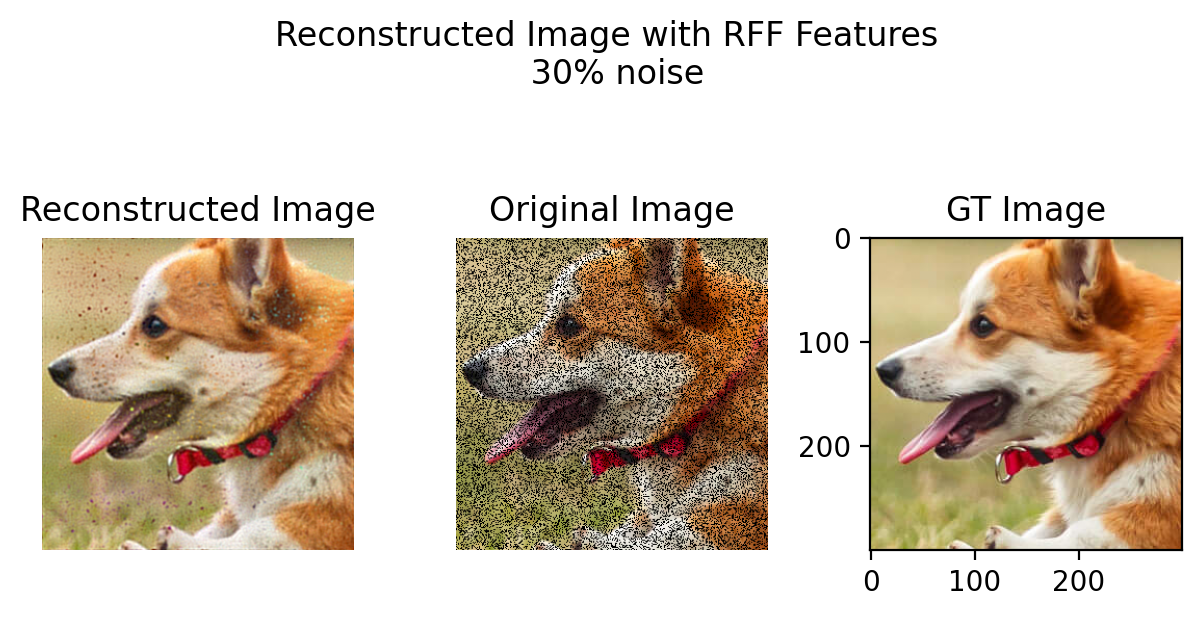

In [6]:
p_value = 0.3
mask = torch.rand(height*width) > p_value

X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff = X_rff.to(device)
# Remove elements where the mask is False
X_rff_mask = X_rff[mask]
X_rff.shape, X_rff_mask.shape

dog_Y_mask = dog_Y[mask]
dog_Y_mask = dog_Y_mask.to(device)
dog_Y_mask.shape

net = LinearModel(X_rff_mask.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_mask, dog_Y_mask, 5000)

crop = crop.to(device)
mask = mask.to(device)

outputs = plot_reconstructed_and_original_image( crop, crop*mask.reshape(300,300), net, X_rff, title="Reconstructed Image with RFF Features \n 30% noise")

rmse_value = calculate_rmse(outputs, crop.reshape(height*width, num_channels))
psnr_value = calculate_psnr(outputs, crop.reshape(height*width, num_channels))

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

### 40% data missing

Epoch 0 loss: 0.371076
Epoch 100 loss: 0.044163
Epoch 200 loss: 0.011553
Epoch 300 loss: 0.005875
Epoch 400 loss: 0.003718


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Stopping criteria met. Improvement in loss less than or equal to 0.000010
---------------------------------------
RMSE: 0.3138627280959977
PSNR: 58.19600870234442


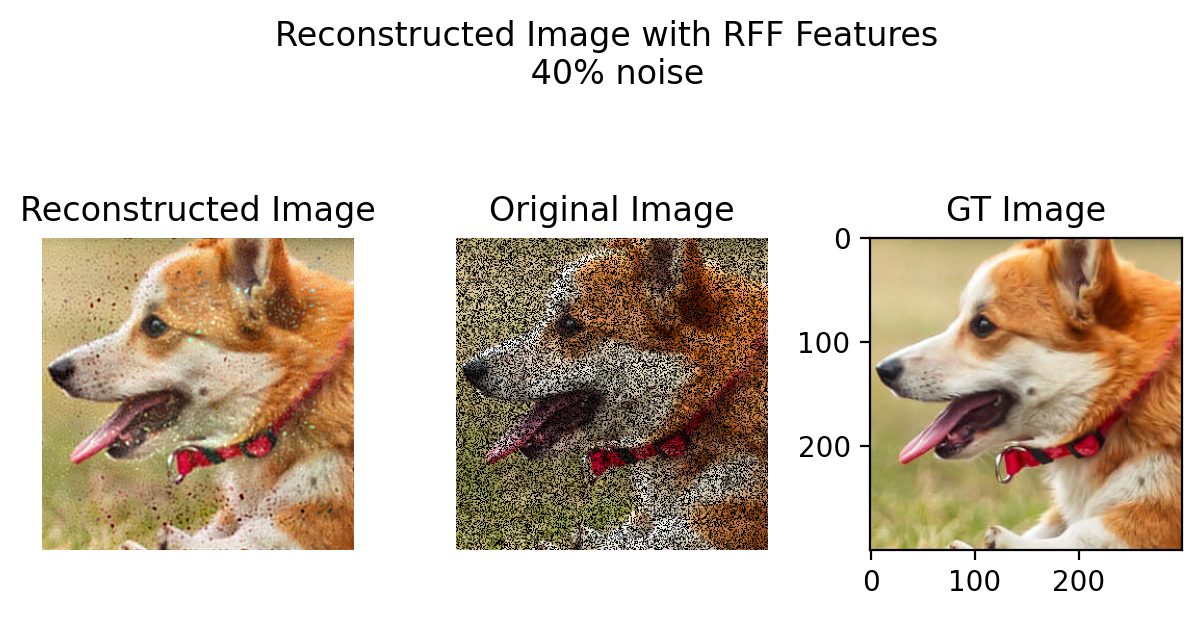

In [7]:
p_value = 0.4
mask = torch.rand(height*width) > p_value

X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff = X_rff.to(device)
# Remove elements where the mask is False
X_rff_mask = X_rff[mask]
X_rff.shape, X_rff_mask.shape

dog_Y_mask = dog_Y[mask]
dog_Y_mask = dog_Y_mask.to(device)
dog_Y_mask.shape

net = LinearModel(X_rff_mask.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_mask, dog_Y_mask, 5000)

crop = crop.to(device)
mask = mask.to(device)

outputs = plot_reconstructed_and_original_image( crop, crop*mask.reshape(300,300), net, X_rff, title="Reconstructed Image with RFF Features \n 40% noise")

rmse_value = calculate_rmse(outputs, crop.reshape(height*width, num_channels))
psnr_value = calculate_psnr(outputs, crop.reshape(height*width, num_channels))

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

### 50% data missing

Epoch 0 loss: 0.368924
Epoch 100 loss: 0.037476
Epoch 200 loss: 0.009060
Epoch 300 loss: 0.003947
Epoch 400 loss: 0.002137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Stopping criteria met. Improvement in loss less than or equal to 0.000010
---------------------------------------
RMSE: 0.3236546289555431
PSNR: 57.929167153855744


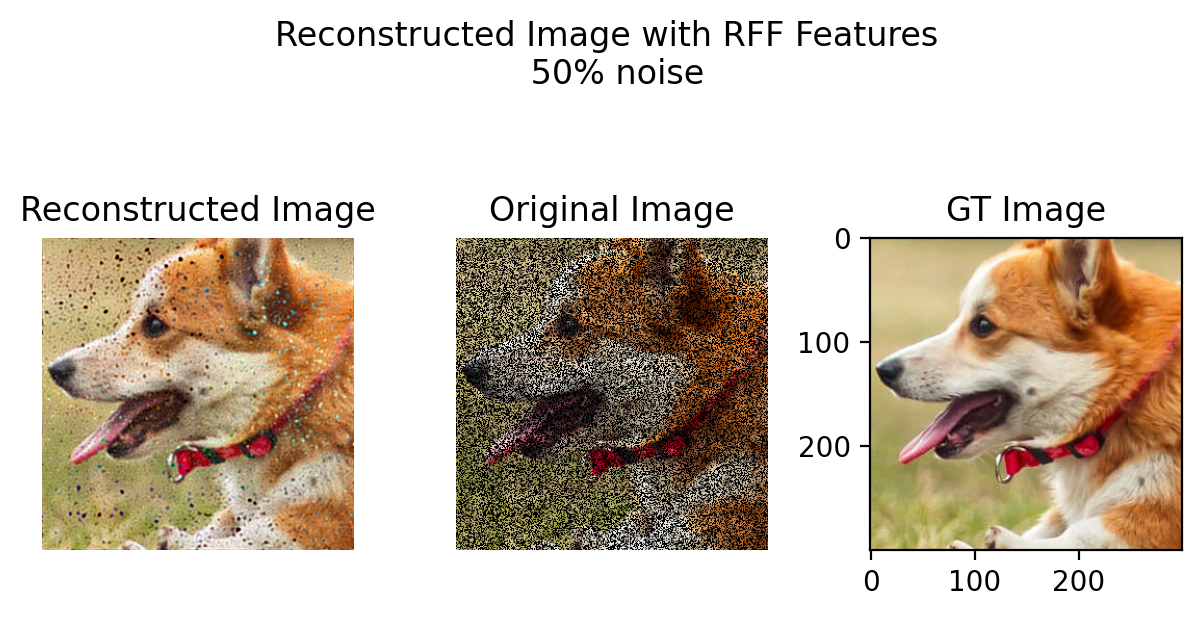

In [8]:
p_value = 0.5
mask = torch.rand(height*width) > p_value

X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff = X_rff.to(device)
# Remove elements where the mask is False
X_rff_mask = X_rff[mask]
X_rff.shape, X_rff_mask.shape

dog_Y_mask = dog_Y[mask]
dog_Y_mask = dog_Y_mask.to(device)
dog_Y_mask.shape

net = LinearModel(X_rff_mask.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_mask, dog_Y_mask, 5000)

crop = crop.to(device)
mask = mask.to(device)

outputs = plot_reconstructed_and_original_image( crop, crop*mask.reshape(300,300), net, X_rff, title="Reconstructed Image with RFF Features \n 50% noise")

rmse_value = calculate_rmse(outputs, crop.reshape(height*width, num_channels))
psnr_value = calculate_psnr(outputs, crop.reshape(height*width, num_channels))

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

### 60% data missing

Epoch 0 loss: 0.372618
Epoch 100 loss: 0.034079
Epoch 200 loss: 0.008900
Epoch 300 loss: 0.004306
Epoch 400 loss: 0.002568


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Stopping criteria met. Improvement in loss less than or equal to 0.000010
---------------------------------------
RMSE: 0.33717595797114547
PSNR: 57.5736716071049


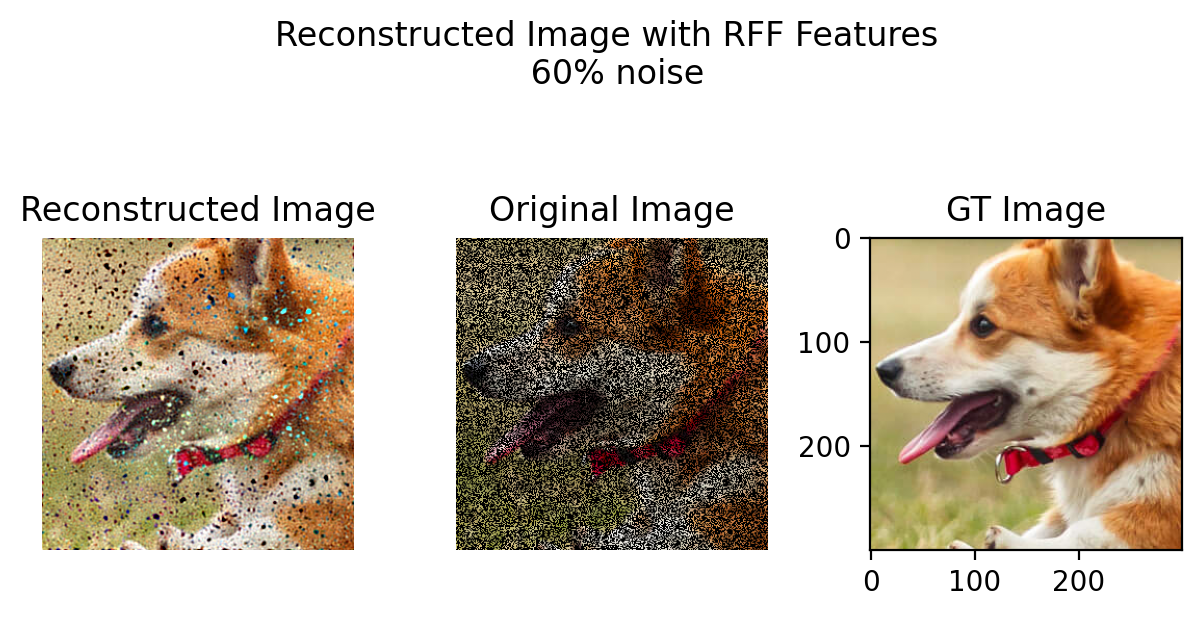

In [9]:
p_value = 0.6
mask = torch.rand(height*width) > p_value

X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff = X_rff.to(device)
# Remove elements where the mask is False
X_rff_mask = X_rff[mask]
X_rff.shape, X_rff_mask.shape

dog_Y_mask = dog_Y[mask]
dog_Y_mask = dog_Y_mask.to(device)
dog_Y_mask.shape

net = LinearModel(X_rff_mask.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_mask, dog_Y_mask, 5000)

crop = crop.to(device)
mask = mask.to(device)

outputs = plot_reconstructed_and_original_image( crop, crop*mask.reshape(300,300), net, X_rff, title="Reconstructed Image with RFF Features \n 60% noise")

rmse_value = calculate_rmse(outputs, crop.reshape(height*width, num_channels))
psnr_value = calculate_psnr(outputs, crop.reshape(height*width, num_channels))

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

### 70% percent data missing

Epoch 0 loss: 0.369159
Epoch 100 loss: 0.025669
Epoch 200 loss: 0.006413
Epoch 300 loss: 0.003143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Stopping criteria met. Improvement in loss less than or equal to 0.000010
---------------------------------------
RMSE: 0.37471200336643845
PSNR: 56.65685150221749


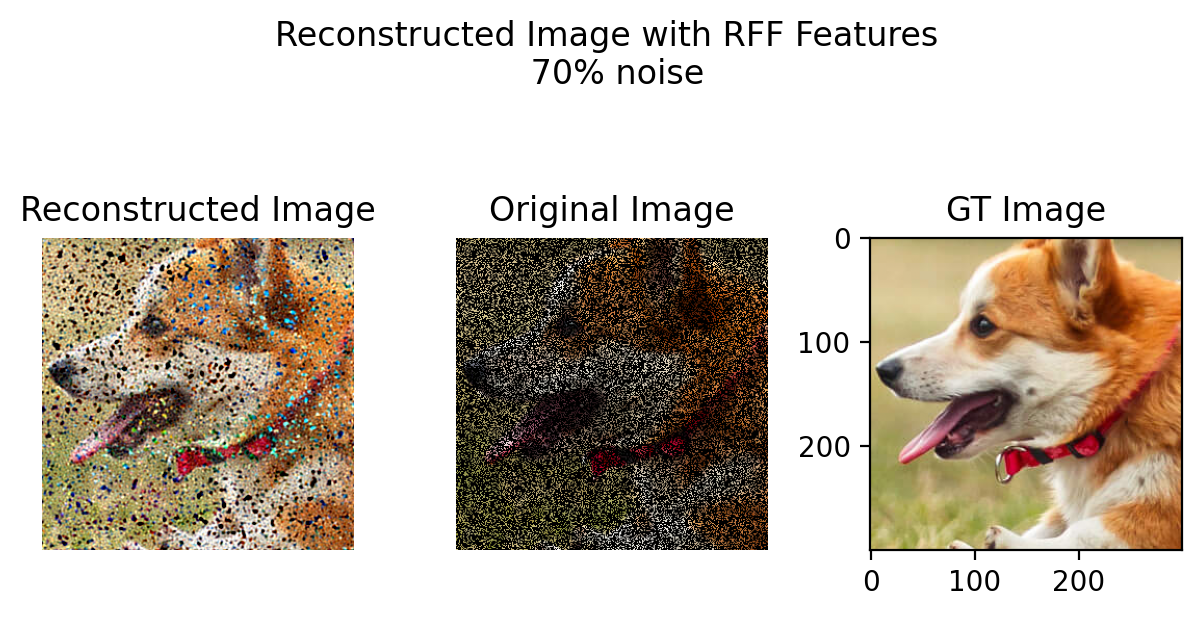

In [10]:
p_value = 0.7
mask = torch.rand(height*width) > p_value

X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff = X_rff.to(device)
# Remove elements where the mask is False
X_rff_mask = X_rff[mask]
X_rff.shape, X_rff_mask.shape

dog_Y_mask = dog_Y[mask]
dog_Y_mask = dog_Y_mask.to(device)
dog_Y_mask.shape

net = LinearModel(X_rff_mask.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_mask, dog_Y_mask, 5000)

crop = crop.to(device)
mask = mask.to(device)

outputs = plot_reconstructed_and_original_image( crop, crop*mask.reshape(300,300), net, X_rff, title="Reconstructed Image with RFF Features \n 70% noise")

rmse_value = calculate_rmse(outputs, crop.reshape(height*width, num_channels))
psnr_value = calculate_psnr(outputs, crop.reshape(height*width, num_channels))

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

### 80% data missing

Epoch 0 loss: 0.370365
Epoch 100 loss: 0.015125
Epoch 200 loss: 0.002866


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Stopping criteria met. Improvement in loss less than or equal to 0.000010
---------------------------------------
RMSE: 0.43717419398090474
PSNR: 55.3177132486367


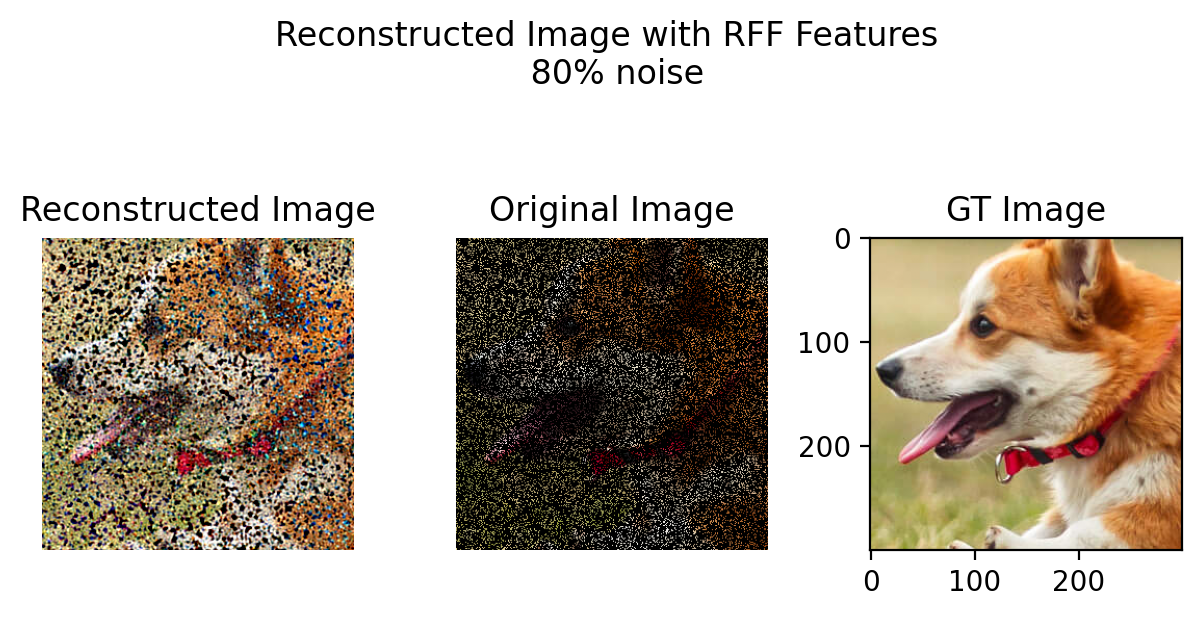

In [12]:
p_value = 0.8
mask = torch.rand(height*width) > p_value

X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff = X_rff.to(device)
# Remove elements where the mask is False
X_rff_mask = X_rff[mask]
X_rff.shape, X_rff_mask.shape

dog_Y_mask = dog_Y[mask]
dog_Y_mask = dog_Y_mask.to(device)
dog_Y_mask.shape

net = LinearModel(X_rff_mask.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_mask, dog_Y_mask, 5000)

crop = crop.to(device)
mask = mask.to(device)

outputs = plot_reconstructed_and_original_image( crop, crop*mask.reshape(300,300), net, X_rff, title="Reconstructed Image with RFF Features \n 80% noise")

rmse_value = calculate_rmse(outputs, crop.reshape(height*width, num_channels))
psnr_value = calculate_psnr(outputs, crop.reshape(height*width, num_channels))

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

### 90% data missing

Epoch 0 loss: 0.368554
Epoch 100 loss: 0.002856


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Stopping criteria met. Improvement in loss less than or equal to 0.000010
---------------------------------------
RMSE: 0.48338216988731586
PSNR: 54.444991070463814


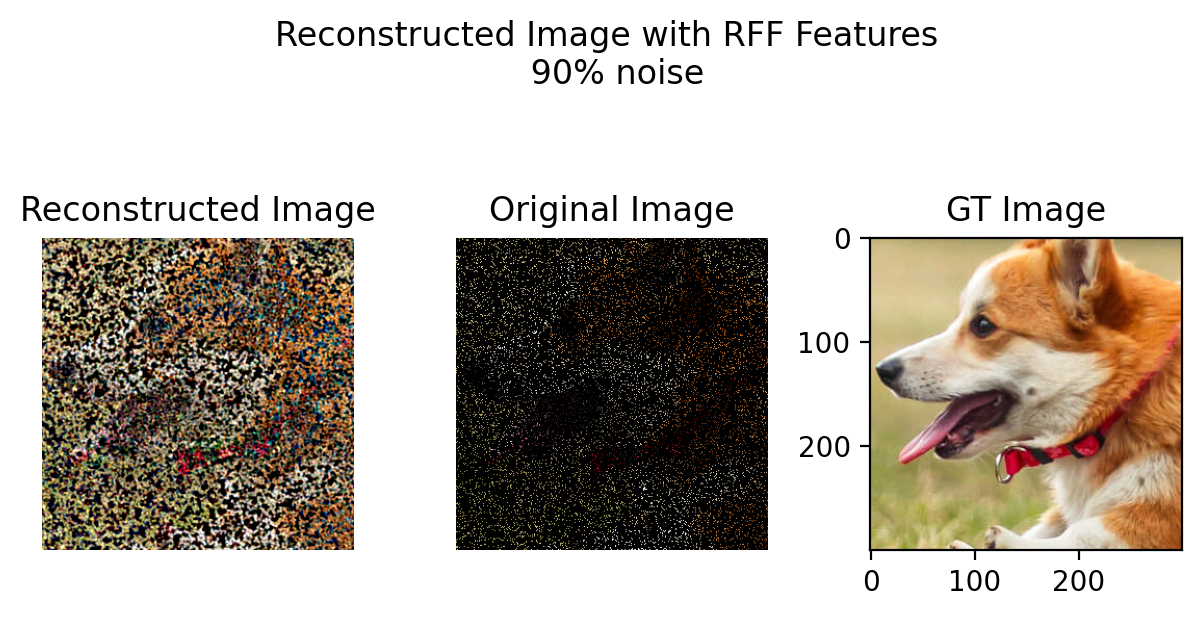

In [13]:
p_value = 0.9
mask = torch.rand(height*width) > p_value

X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)
X_rff = X_rff.to(device)
# Remove elements where the mask is False
X_rff_mask = X_rff[mask]
X_rff.shape, X_rff_mask.shape

dog_Y_mask = dog_Y[mask]
dog_Y_mask = dog_Y_mask.to(device)
dog_Y_mask.shape

net = LinearModel(X_rff_mask.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff_mask, dog_Y_mask, 5000)

crop = crop.to(device)
mask = mask.to(device)

outputs = plot_reconstructed_and_original_image( crop, crop*mask.reshape(300,300), net, X_rff, title="Reconstructed Image with RFF Features \n 90% noise")

rmse_value = calculate_rmse(outputs, crop.reshape(height*width, num_channels))
psnr_value = calculate_psnr(outputs, crop.reshape(height*width, num_channels))

print('---------------------------------------')
print(f"RMSE: {rmse_value}")
print(f"PSNR: {psnr_value}")

- As the mask percentage increases, you may observe an increase in RMSE. This is because a higher mask percentage corresponds to a greater portion of the image being hidden or set to zero. Consequently, the predicted values might deviate more from the ground truth, leading to higher RMSE values.

- Conversely, as the mask percentage increases, PSNR values may decrease. Higher mask percentages often introduce more noise or distortion in the reconstructed image, resulting in lower PSNR values. A lower PSNR indicates poorer image quality.

### General Observations:

- Lower mask percentages (e.g., 10-30%) may result in better reconstruction quality, as there is less information being masked.
- Moderate mask percentages (e.g., 40-60%) might show a balance between retaining image details and introducing some level of distortion.
- Higher mask percentages (e.g., 70-90%) often lead to more noticeable degradation in image quality, with increased errors in the reconstructed regions.

There are some deviations from general observation, from 10% to 20% and from 30% to 40%, the RMSE values increase sligtly instead of decreasing. If the pixels in the 10-20% and 30-40% ranges have specific patterns or features that make them more challenging for the algorithm, it could result in unexpected fluctuations in RMSE.